In [2]:
import numpy as np
from scipy.stats import multivariate_normal, dirichlet, wishart
from tqdm import tqdm
import matplotlib.pyplot as plt

In [298]:
def gibbs_mixture_gaussian(X, K, num_iterations, pi=None, mu=None, sigma=None):
    N, D = X.shape  # N: number of data points, D: dimensionality

    # 目的とする混合ガウス分布のパラメータの初期値
    if pi is None:
        pi = np.ones(K) / K  # mixture weights
        print('OK1')
    if mu is None:
        mu = np.random.randn(K, D)  # means
        # mu = np.repeat([np.mean(X, axis=0)], K, axis =0)
        print('OK2')
    if sigma is None:
        sigma = np.array([np.eye(D) for _ in range(K)])  # covariance matrices
        print('OK3')
    # print(pi)
    # print(mu)
    # print(sigma)

    # 潜在変数z（=i番目のデータがk番目のガウスから生じた確率の分布（カテゴリカル分布）
    # の初期値
    z = np.random.choice(K, N)  
    
    # イテレーションのループ
    # 本当は収束の判定をする方がいいらしいが，ここでは指定回のループ
    for it in tqdm(range(num_iterations)):
        
        # print(f'pi:{pi}')
        # print(f'mu:{mu}')
        # print(f'sigma:{sigma}')
        # ===
        # 潜在変数zの分布をサンプリングする．（固定した混合ガウス分布のパラメータのもとで）
        for i in range(N):
            # データiが現在のk番目のガウス分布から得られる確率を求める．
            # 混合係数×尤度（を正規化する）
            # print(X[i])
            p = np.array([pi[k] * (multivariate_normal.pdf(X[i], mu[k], sigma[k]) + 1e-7)for k in range(K)])
            
            # for k in range(K):
            #     print(mu[k], sigma[k])
            # print(f'前P:{p}')
            p /= p.sum()
            # print(f'後P:{p}')
            # print(f'P合計:{p.sum()}')
            z[i] = np.random.choice(K, p=p)

        # ===
        # zが決まったので，その元での混合ガウス分布の各パラメータをサンプリングする．
        # パラメータは1. 混合係数pi，2. 各ガウス成分の平均m_k， 3. 各ガウス成分の共分散行列sigma_kの３つ．
        # ここのサンプリング自体は，混合ガウス分布の場合は，こうすると計算しやすいからそうなっているだけで深くきにしなくていい
        
        # p1. iのサンプリング
        alpha = np.array([np.sum(z == k) for k in range(K)]) + 1  # 一様な混合係数を示す事前分布（決めたzのもとで）
        pi = dirichlet.rvs(alpha)[0]

        #  2. mu_k 3. sigma_kのサンプリング
        for k in range(K):
            Xk = X[z == k] # クラスタkに割り当てられた観測たちXk
            nk = len(Xk) # その数
            if nk == 0:
                continue

            # 各パラメータの更新のための，事前分布の設定
            # 平均の事前分布にはガウス分布，共分散行列は逆ウィシャート分布をつかう．大体こうすると決まっている．
            # ハイパーパラメータも大体こうするらしい．
            m0 = np.zeros(D) # 平均の事前分布のハイパーパラメータ
            beta = 1.0 # 平均の事前分布のハイパーパラメータ
            nu = D # 共分散行列の事前分布のハイパーパラメータ
            S0 = np.eye(D) # 共分散行列の事前分布のハイパーパラメータ

            # ガウスkの平均の更新
            beta_k = beta + nk
            # m_k = (beta * m0 + nk * Xk.mean(axis=0)) / beta_k
            # 共分散行列の更新
            S_k = S0 + np.dot((Xk - Xk.mean(axis=0)).T, Xk - Xk.mean(axis=0)) + beta * nk * np.dot(m0 - Xk.mean(axis=0), m0 - Xk.mean(axis=0).T) / beta_k
            nu_k = nu + nk
            
            Xk_mean = Xk.mean(axis=0)
            m_k = (beta * m0 + nk * Xk_mean) / beta_k

            # sigma[k] = wishart.rvs(df=nu_k, scale=S_k)
            sigma[k] = wishart.rvs(df=nu_k, scale=np.linalg.inv(S_k))

            # 更新されたハイパーパラメータと共分散行列のサンプルを使用して、平均のサンプリング
            mu[k] = np.random.multivariate_normal(m_k, np.linalg.inv(beta_k * sigma[k]))

    return pi, mu, sigma

In [240]:
x = np.array([[0.43496021, 0.02365666]])
m = np.array([
    [-0.37038152 , 1.38994348],
    [-1.03022399 , -0.5553664 ],
    [ 0.93724666 ,  0.81732038]])
m = np.array([
    [50 , 80],
    [100 , -90],
    [180 , 280]])
s = np.array(
    [[[1.,0.],
      [0.,1.]],
     [[1.,0.],
      [0.,1.]],
     [[1.,0.],
      [0.,1.]]])
pi = np.array([0.33333333, 0.33333333, 0.33333333])

a = np.array([pi[k] * (multivariate_normal.pdf(x[0], m[k], s[k]) )for k in range(3)])
# for k in range(3):
#     a = multivariate_normal.pdf(x[0], m[k], s[k])
print(a)
a /= a.sum()
print(a)

print(multivariate_normal.pdf(x[0], m[0], s[0]))
print(multivariate_normal(m[0],s[0])).pdf(x[0])

[0. 0. 0.]
[nan nan nan]
0.0


C:\Users\ma3sh\AppData\Local\Temp\ipykernel_924\1181909898.py:23: RuntimeWarning: invalid value encountered in divide
  a /= a.sum()


AttributeError: 'NoneType' object has no attribute 'pdf'

In [198]:
# [86  1]
# [74.95477136  6.90691728] [[ 0.00437882 -0.00190387]
#  [-0.00190387  0.0156803 ]]
# [110.95263478   6.37308914] [[ 0.00571015 -0.00332578]
#  [-0.00332578  0.00835699]]
# [82.95142795 45.89843531] [[ 0.00160415 -0.00050585]
#  [-0.00050585  0.00090166]]
# 前P:[0. 0. 0.]

print(multivariate_normal.pdf([86, 1], [74.95477136 , 6.90691728], [[ 0.00437882,-0.00190387],[-0.00190387,0.0156803 ]]))

0.0


[8.6 0.1]


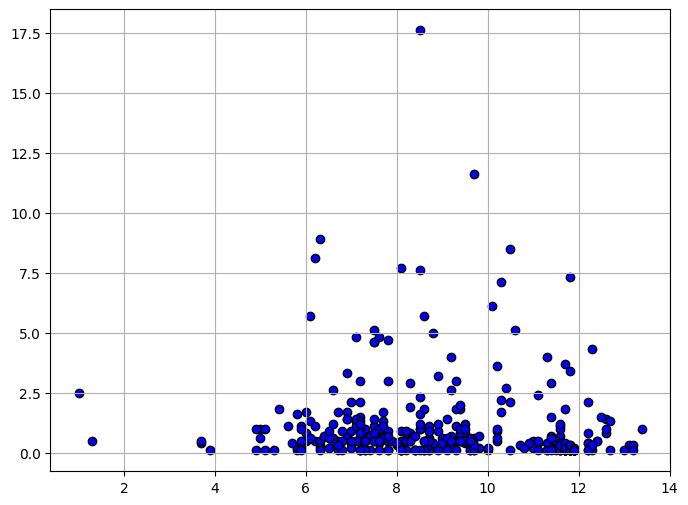

In [285]:
# OD_dataの読み込みと表示
# X = np.random.randn(100, 2)
X = np.load('od_data.npy')
X = X.astype(float)
X /= 100.0
print(X[0])

# Plotting
plt.figure(figsize=(8, 6))  # Create a new figure with a specific size (optional)
plt.scatter(X[:, 0], X[:, 1], color='blue', edgecolors='k')  # scatter plot
plt.grid(True)
plt.show()  

In [215]:
K = 3  # 混合ガウス分布のガウスの数
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 100)

OK1
OK2
OK3
[0.33333333 0.33333333 0.33333333]
[[ 1.17782087 -1.87764468]
 [ 0.10002697  0.82559835]
 [ 0.0366189   1.97488878]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\ma3sh\AppData\Local\Temp\ipykernel_924\839674604.py:37: RuntimeWarning: invalid value encountered in divide
  p /= p.sum()
  0%|          | 0/100 [00:00<?, ?it/s]

[86  1]
[ 1.17782087 -1.87764468] [[1. 0.]
 [0. 1.]]
[0.10002697 0.82559835] [[1. 0.]
 [0. 1.]]
[0.0366189  1.97488878] [[1. 0.]
 [0. 1.]]
前P:[0. 0. 0.]


ValueError: probabilities contain NaN

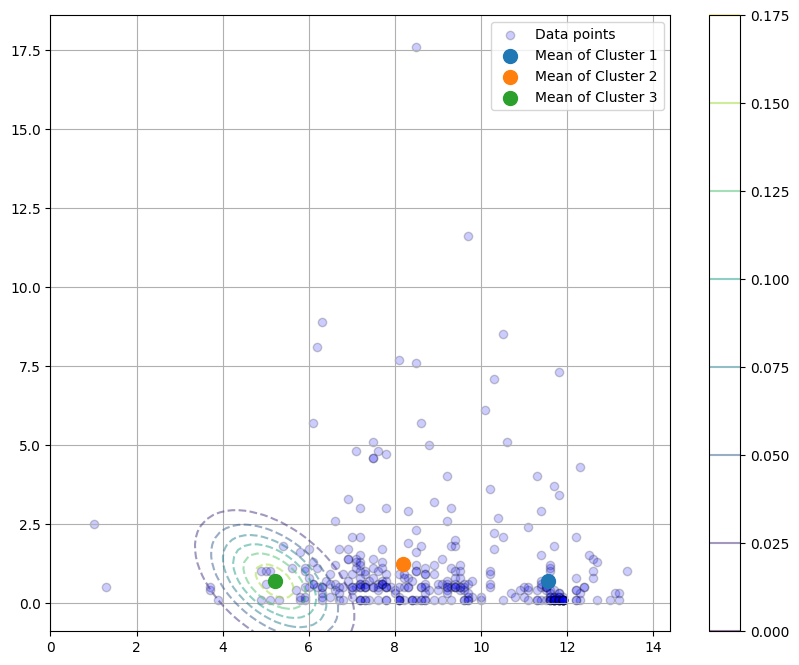

In [300]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

def plot_mixture_gaussian(X, pi, mu, sigma):
    plt.figure(figsize=(10, 8))

    # Scatter plot of data points
    plt.scatter(X[:, 0], X[:, 1], color='blue', edgecolors='k', alpha=0.2, label='Data points')

    # Plot each Gaussian distribution
    x = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, 100)
    y = np.linspace(min(X[:, 1]) - 1, max(X[:, 1]) + 1, 100)
    Xgrid, Ygrid = np.meshgrid(x, y)

    for k in range(len(pi)):
        Z = multivariate_normal.pdf(np.dstack((Xgrid, Ygrid)), mean=mu[k], cov=sigma[k])
        # plt.contour(Xgrid, Ygrid, Z, alpha=0.5, linestyles='--')
        plt.scatter(mu[k][0], mu[k][1], marker='o', s=100, color='red', label=f'Mean of Cluster {k+1}')

    plt.contour(Xgrid, Ygrid, Z, alpha=0.5, linestyles='--')

    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_mixture_gaussian(X, pi, mu, sigma)

In [12]:
# よくわからいので，適当な混合ガウス分布を作って架空データをつｋる
np.random.seed(42)
num_samples = 300
K = 3

# True parameters
true_pi = [0.4, 0.3, 0.3]
true_mu = np.array([[1, 3], [-2, -2], [3, -2]])
true_sigma = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0.3], [0.3, 1]]])

X = []
for _ in range(num_samples):
    k = np.random.choice(K, p=true_pi)
    x = np.random.multivariate_normal(true_mu[k], true_sigma[k])
    X.append(x)
X = np.array(X)

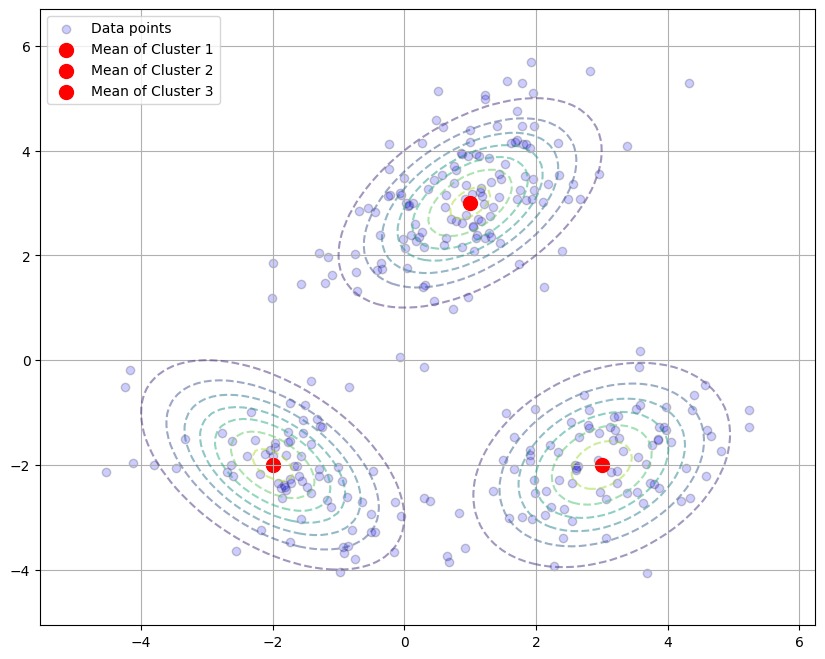

In [13]:
plot_mixture_gaussian(X, true_pi, true_mu, true_sigma)

100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


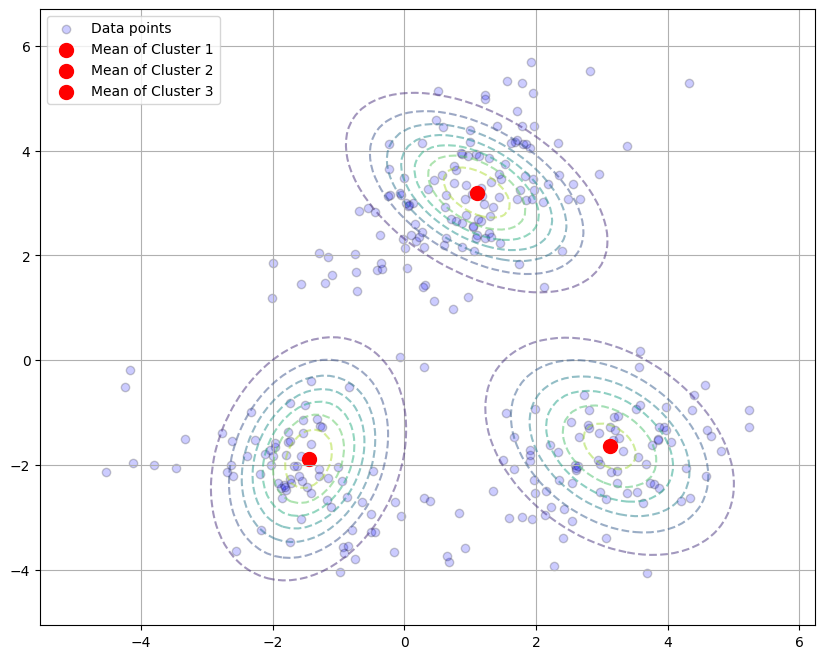

In [14]:
# 100イテレーション
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 100)
plot_mixture_gaussian(X, pi, mu, sigma)

100%|██████████| 1000/1000 [02:27<00:00,  6.80it/s]


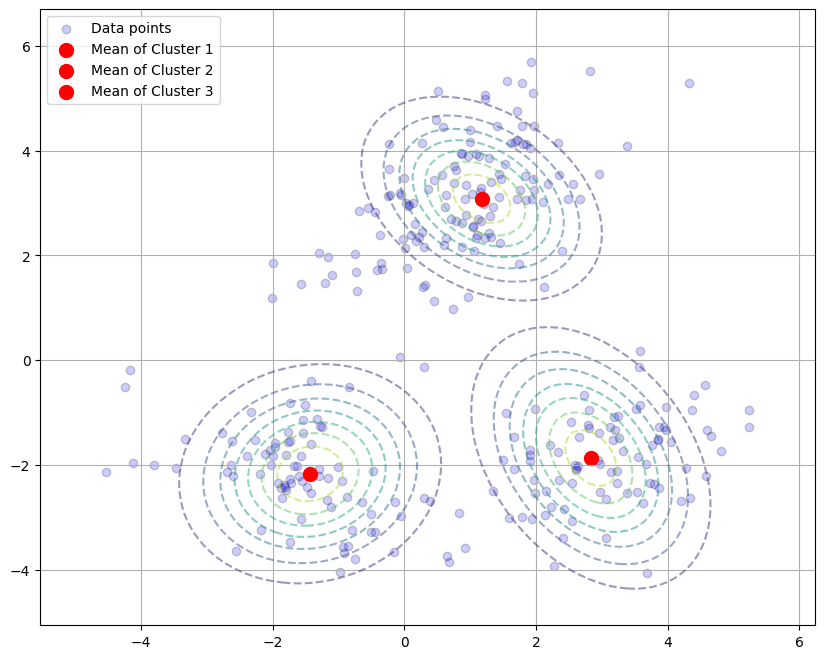

In [16]:
# 1000イテレーション
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 1000)
plot_mixture_gaussian(X, pi, mu, sigma)

100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]


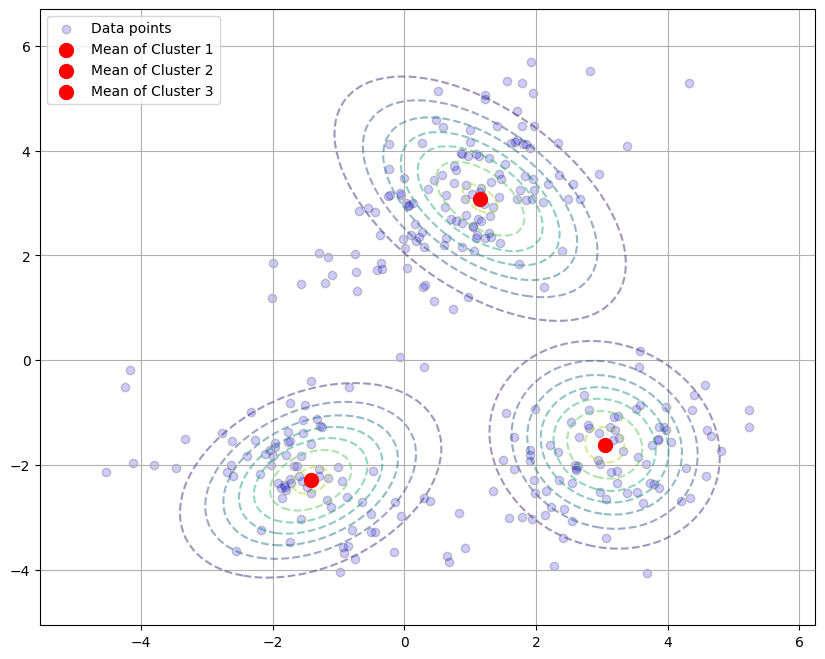

In [17]:
# 5000イテレーション
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 5000)
plot_mixture_gaussian(X, pi, mu, sigma)

In [296]:
from sklearn.cluster import KMeans

def initialize_parameters_with_kmeans(X, K):
    # K-meansクラスタリング
    kmeans = KMeans(n_clusters=K).fit(X)

    # クラスタの中心を初期平均値とする
    mu_init = kmeans.cluster_centers_

    # クラスタの分散を初期共分散とする & クラスタのデータ点の比率を初期混合比とする
    sigma_init = []
    pi_init = []
    labels = kmeans.labels_
    for k in range(K):
        cluster_data = X[labels == k]
        sigma_init.append(np.cov(cluster_data, rowvar=False))
        pi_init.append(len(cluster_data) / len(X))

    return np.array(pi_init), mu_init, np.array(sigma_init)

# この関数を使って、Gibbsサンプリングの初期値を設定
pi_init, mu_init, sigma_init = initialize_parameters_with_kmeans(X, K)

c:\Users\ma3sh\OneDrive\デスクトップ\test_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


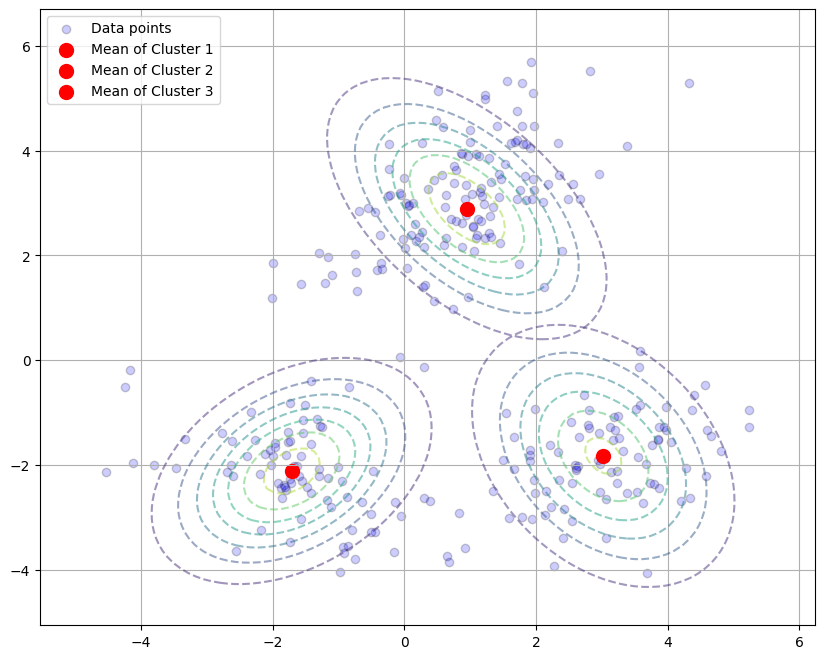

In [19]:
# 1000イテレーション
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 1000, pi_init, mu_init, sigma_init)
plot_mixture_gaussian(X, pi, mu, sigma)

In [236]:
pi_init, mu_init, sigma_init = initialize_parameters_with_kmeans(X, 10)

c:\Users\ma3sh\OneDrive\デスクトップ\test_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

c:\Users\ma3sh\OneDrive\デスクトップ\test_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


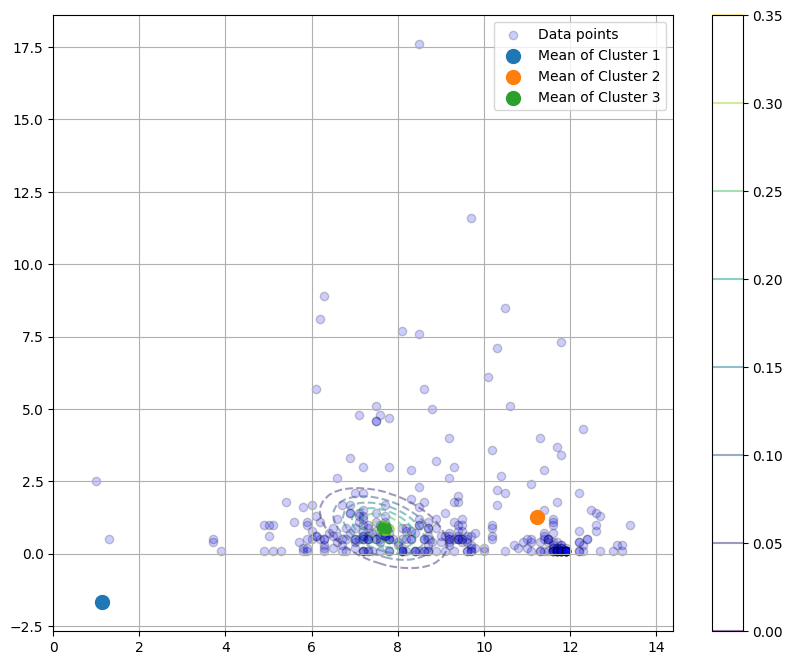

In [301]:
# values_to_remove = np.array([[86, 1], [62, 5]])
# # 条件を指定して値を削除
# condition = np.all(X != values_to_remove[:, np.newaxis, :], axis=2)
# A = X[np.any(condition, axis=1)]
# print(A)

pi_init, mu_init, sigma_init = initialize_parameters_with_kmeans(X, K)
# print(pi_init, type(pi_init))
# print(mu_init, type(mu_init))
# print(sigma_init, type(sigma_init))
# 100イテレーション
pi, mu, sigma = gibbs_mixture_gaussian(X, K, 100, pi_init, mu_init, sigma_init)
# pi, mu, sigma = gibbs_mixture_gaussian(X, K, 100)
plot_mixture_gaussian(X, pi, mu, sigma)

In [263]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]

# 確率密度関数の計算
x = [27, 27]  # 計算したい点の座標
pdf_value = multivariate_normal.pdf(x, mean=mean, cov=cov)

pdf_value += 1e-7

pdf_value *= 0.3333333

print(pdf_value)

3.333333e-08
